##ThinkDSP

This notebook contains code examples from Chapter 10: Signals and Systems

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import math
import numpy as np
import pandas
import scipy.signal

PI2 = 2 * math.pi

%precision 3
%matplotlib inline

Here's a recording of a gunshot, which approximates the acoustic impulse response of the room:

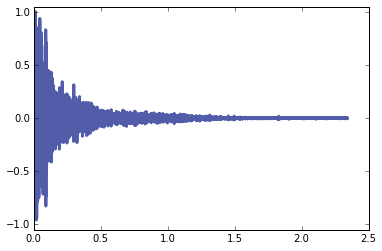

In [4]:
response = thinkdsp.read_wave('180961__kleeb__gunshots.wav')
response = response.segment(start=0.26, duration=5.0)
response.normalize()
response.plot()
thinkplot.config(ylim=[-1.05, 1.05], legend=False)

Here's what it sounds like:

In [5]:
response.make_audio()

The DFT of the impulse response is the transfer function:

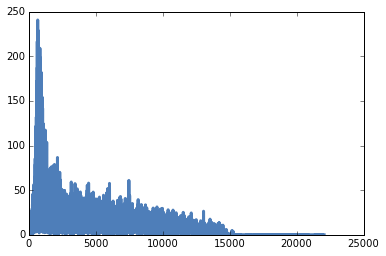

In [6]:
transfer = response.make_spectrum()
transfer.plot()

Here's the transfer function on a log-log scale:

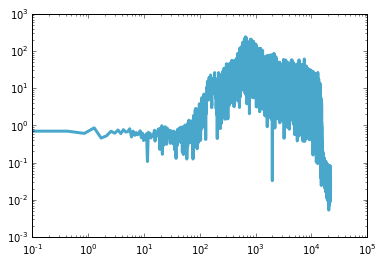

In [7]:
transfer.plot()
thinkplot.config(xscale='log', yscale='log')

Now we can simulate what a recording would sound like if it were played in the same room and recorded in the same way.  Here's the violin recording we have used before:

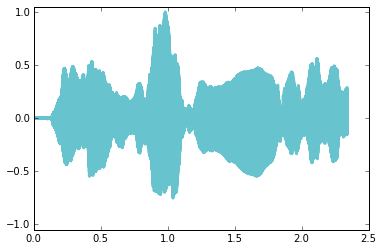

In [8]:
violin = thinkdsp.read_wave('92002__jcveliz__violin-origional.wav')
violin.ys = violin.ys[:len(response)]
violin.normalize()
violin.plot()
thinkplot.config(ylim=[-1.05, 1.05])

Here's what it sounds like before transformation:

In [9]:
violin.make_audio()

Now we compute the DFT of the violin recording.

In [10]:
spectrum = violin.make_spectrum()

I trimmed the violin recording to the same length as the impulse response:

In [11]:
len(spectrum.hs), len(transfer.hs)

(51589, 51589)

We we can multiply in the frequency domain and the transform back to the time domain.

In [12]:
output = (spectrum * transfer).make_wave()
output.normalize()

Here'a  comparison of the original and transformed recordings:

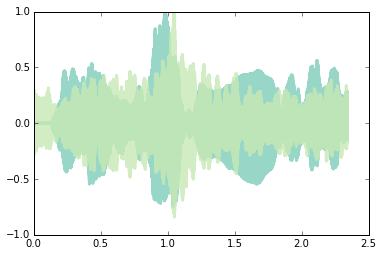

In [13]:
violin.plot()
output.plot()

And here's what it sounds like:

In [14]:
output.make_audio()

To understand how that worked, you can think about the input signal as a series of impulses, and the output as the sume of shifted, scaled versions of the impulse response.

In [15]:
def shifted_scaled(wave, shift, factor):
    res = wave.copy()
    res.shift(shift)
    res.scale(factor)
    return res

Here's what it would sound like if we fired a big gun followed by a small gun:

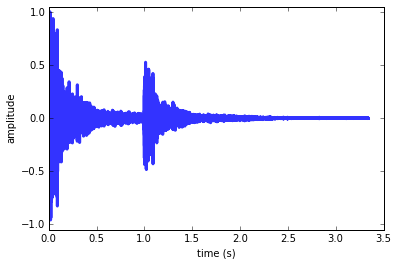

In [16]:
dt = 1
shift = dt * response.framerate
factor = 0.5

response2 = response + shifted_scaled(response, shift, factor)
response2.plot()
thinkplot.config(xlabel='time (s)', ylabel='amplitude', ylim=[-1.05, 1.05])

Two gunshots:

In [18]:
response2.make_audio()

Here's what it sounds like if we fire 100 guns at a rate of 441 gunshots per second:

In [19]:
total = 0
for j in range(100):
    total += shifted_scaled(response, j*100, 1.0)
total.normalize()

In [21]:
total.make_audio()

The result has a fundamental frequency at 441, with additional harmonics.

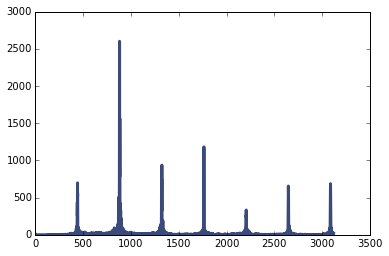

In [22]:
total.make_spectrum().plot(high=8000)

Now let's do the same thing with a sawtooth signal:

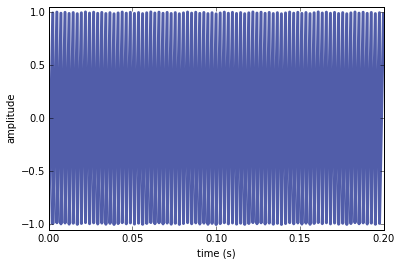

In [23]:
sawtooth = thinkdsp.SawtoothSignal(freq=410).make_wave(duration=0.2, framerate=response.framerate)
sawtooth.plot()
thinkplot.config(xlabel='time (s)', ylabel='amplitude', ylim=[-1.05, 1.05])

Here's what it sounds like:

In [25]:
sawtooth.make_audio()

And here's what we get if we use the sawtooth to generate shifted, scaled versions of the impulse response:

In [26]:
total = 0
for j, y in enumerate(sawtooth.ys):
    total += shifted_scaled(response, j, y)
total.normalize()

The result is a simulation of what the sawtooth signal would sound like if it was recorded in the room where the gunshot was recorded:

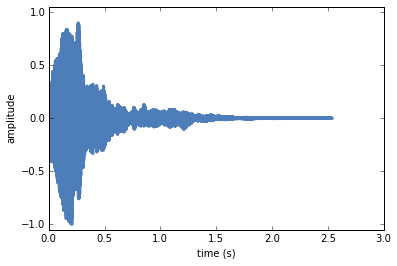

In [27]:
total.plot()
thinkplot.config(xlabel='time (s)', ylabel='amplitude', ylim=[-1.05, 1.05])

And here's what it sounds like:

In [29]:
total.make_audio()

To me it sounds a bit like a car horn in a garage.

And here's the spectrum:

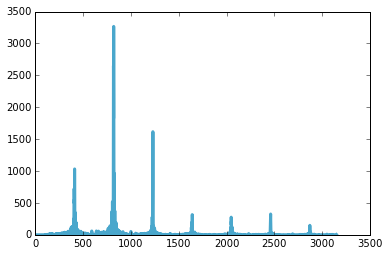

In [30]:
total.make_spectrum().plot(high=8000)

Here's a comparison before and after convolution:

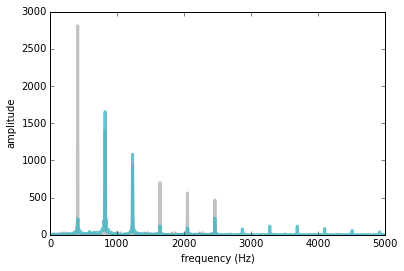

In [31]:
sawtooth.make_spectrum().plot(high=500, color='0.7')

segment = total.segment(duration=0.2)
segment.make_spectrum().plot(high=1000)
thinkplot.config(xlabel='frequency (Hz)', ylabel='amplitude')

Now that we recognize this operation as convolution, we can compute it using the convolve method:

In [33]:
convolved = sawtooth.convolve(response)
convolved.normalize()
convolved.make_audio()

And we can do the same thing with the violin recording:

In [34]:
convolved2 = violin.convolve(response)
convolved2.normalize()
convolved2.make_audio()

To understand why the impulse response is sufficient to characterize a system, it is informative to look at the DFT of an impulse:

In [35]:
impulse = np.zeros(8)
impulse[0] = 1
print(impulse)

[ 1.  0.  0.  0.  0.  0.  0.  0.]


The DFT of an impulse is all ones, which means that the impulse contains equal energy at all frequencies.  So testing a system with an impulse is like testing it will all frequency components at the same time:

In [36]:
spectrum = np.fft.fft(impulse)
print(spectrum)

[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]


You might notice something about the impulse and its DFT:

In [37]:
np.sum(np.absolute(impulse)**2)

1.000

In [38]:
np.sum(np.absolute(spectrum)**2)

8.000

In general, the total magnitue of DFT(y) is N times the total magnitude of y.

Finally, let's look at a mini example of system characterization.  Suppose you have a system that smooths the signal by taking a moving average of adjacent elements:

In [39]:
window = np.array([0.5, 0.5, 0, 0, 0, 0, 0, 0,])

For this moving average window, we can compute the transfer function:

In [40]:
filtr = scipy.fftpack.fft(window)
filtr

array([ 1.000+0.j   ,  0.854-0.354j,  0.500-0.5j  ,  0.146-0.354j,
        0.000+0.j   ,  0.146+0.354j,  0.500+0.5j  ,  0.854+0.354j])

Here are the magnitudes:

In [41]:
np.absolute(filtr)

array([ 1.   ,  0.924,  0.707,  0.383,  0.   ,  0.383,  0.707,  0.924])

To visualize the transfer function, I'll roll it so that frequency 0 is in the middle.  The DFT of a smoothing window is approximately Gaussian:

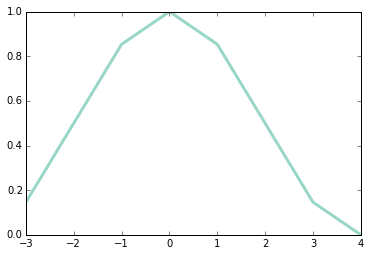

In [42]:
rolled = np.roll(filtr, 3)
thinkplot.plot([-3, -2, -1, 0, 1, 2, 3, 4], rolled.real)

If you multiply the transfer function by the spectrum of an impulse (which is all ones), the result is the filter:

In [43]:
product = spectrum * filtr
print(product)

[ 1.000+0.j     0.854-0.354j  0.500-0.5j    0.146-0.354j  0.000+0.j
  0.146+0.354j  0.500+0.5j    0.854+0.354j]


Now if you transform back to the time domain, you have the impulse response, which looks a lot like the window:

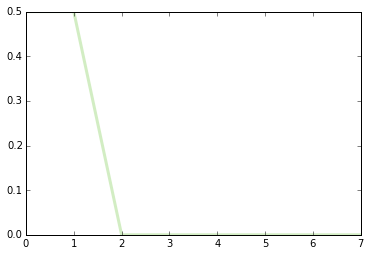

In [44]:
filtered = scipy.fftpack.ifft(product)
thinkplot.plot(filtered.real)

In [45]:
print(filtered.real)

[  5.000e-01   5.000e-01   0.000e+00   0.000e+00   0.000e+00   2.776e-17
   0.000e+00   0.000e+00]


This example is meant to demonstrate why a recording of an impulse response is sufficient to characterize a system: because it is the IDFT of the transfer function.